# Exercise 10: Maximum likelihood estimation

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import scipy
from scipy.optimize import minimize
plt.rcParams['text.usetex'] = True

## Ex 1: Particle decay

In this exercise, we will numerically investigate Example 4 (see chapter 9 of the lecture notes).

A radioactive source emits $n$ unstable particles. The particles are emitted at a constant speed along the $x$ axis. For each particle, indexed by  $i\in\{1,\dots,n\}$, we mark the  position $x_i$ where it decays. Our detector however only detects decays between $x_{min}$ and $x_{max}$.

The probability density of decaying at $x$ is 
$$
\rho(x|\lambda_*)=\frac{e^{-x/\lambda_*} }{\lambda_* \left(e^{-x_{min}/\lambda_*}-e^{-x_{max}/\lambda_*}\right)}
$$
for an unknown parameter $\lambda_*$. As we saw in Example 3 of the lecture notes, $\lambda_*$ denotes the true mean of the decay distance. We expect the mean of the observations to be, however, in general different from $\lambda_*$ due to the restriction of the observations to the range $[x_{min},x_{max}]$.

Given the dataset of $n$ measurements $\mathbf x=(x_1,\dots,x_n)$ our objective is to estimate $\lambda_*$.

Suppose that $x_{min}=0.5,x_{max}=3$ are fixed. We consider two cases:
1. $\lambda_* = 2$
2. $\lambda_* = 4$

Note that in case $1$, $\lambda_*$ lies within the range $[x_{min},x_{max}]$ while in case $2$, $\lambda_*$ is outside the range of measurements.

In [3]:
xmin=0.5
xmax=3
lambda_stars=[2,4] #value of the parameter that we want to estimate. Also said "ground truth".

### Ex 1.1: simulating the particle decay

Your first task is to simulate this physical system, namely to generate the dataset $x_1, x_2, \dots, x_n$ given the true value $\lambda_*$.

To generate the data $\pmb x$, you will use the so called *rejection method*. 
The idea is that the p.d.f. from which we want to sample is just a truncated exponential, i.e. an exponential with scale parameter $\lambda_*$ in which we discard events in which $x < x_{\rm min}$ or $x > x_{\rm max}$.
Thus, we can just generate exponential random numbers using `np.random.exponential` one by one. 
For each sample, we check if $x_{\rm min} < x < x_{\rm max}$. If this is the case, we keep this sample, otherwise we discard it. 
We iterate the procedure until we have $n$ valid measurements.

**1.1.1**

Write a function that takes as input $n$, $\lambda_*$, $x_{\rm min}$ and $x_{\rm max}$ and generates the dataset as a lenght $n$ vector. 

In [4]:
# Solution
def generate_dataset_decay(n, lambda_star, xmin, xmax):
    samples = []
    while len(samples)<n:
        x = np.random.exponential(scale = lambda_star)
        if xmin <= x <= xmax:
            samples = np.append(samples, x)
    return samples

**1.1.2**

Generate datasets with $n=2000, x_{min}=0.5,x_{max}=3$ and $\lambda_*=2,4$ for the two cases. Plot the histograms in both cases. 
Use ```density = True``` (to have the histogram represent a p.d.f.) and the x axis limits to $(0, 5)$.

You will observe the truncations at $x_{min}$ and $x_{max}$ and (albeit very noisily) the exponential decay of the distribution.

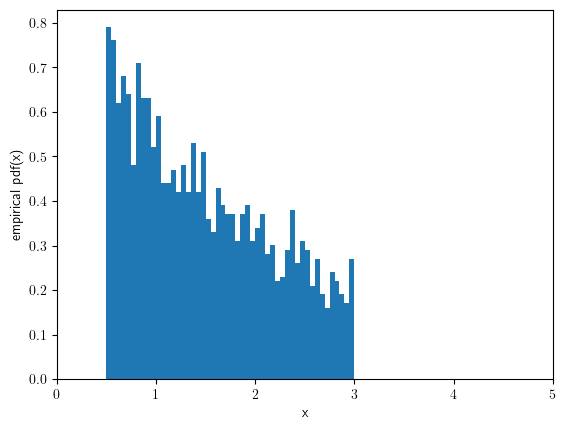

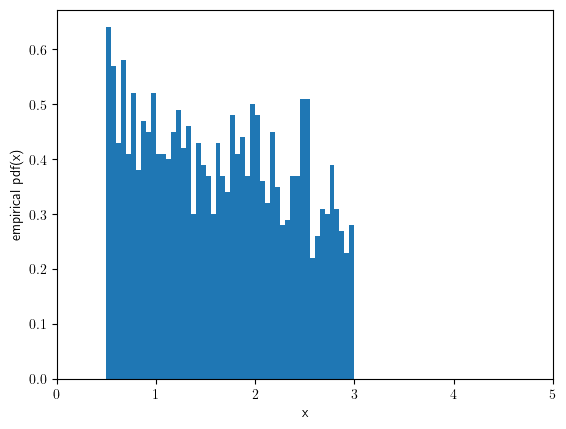

In [5]:
# Solution
n = 2000
dataset_decays = []
for lambda_star in lambda_stars:
    dataset_decays.append(generate_dataset_decay(n, lambda_star, xmin, xmax))

for dataset_decay in dataset_decays:
    plt.hist(dataset_decay, bins = 50, density = True)
    plt.xlabel("x")
    plt.ylabel("empirical pdf(x)")
    plt.xlim(0,5)
    plt.show()

### Ex 1.2: computing the maximum likelihood estimator

Review Example 4 in chapter 9 of the lecture notes. There, we derived the maximum likelihood estimator for $\lambda_*$ as 
$$
\hat{\lambda} 
    = \arg\max_{\lambda} \frac{e^{-\frac{1}{\lambda n}\sum_{i=1}^n x_i} }{\lambda \left( e^{-x_{\rm min} / \lambda} - e^{-x_{\rm max} / \lambda} \right)}  
    = \arg\max_{\lambda} \mathcal{L}(\lambda)
    \, .
$$
It is easier to work with the negative normalized log-likelihood $- \frac{1}{n} \log \mathcal{L}(\lambda)$, which needs to be minimised (due to the negative sign), giving
$$
    \hat \lambda=\arg\min_\lambda \ell(\lambda)
$$
where
$$
\ell(\lambda) =
\log\lambda + \log\left(e^{-x_{min}/\lambda}-e^{-x_{max}/\lambda}\right) + \frac{1}{\lambda} \frac{1}{n}\sum_{i=1}^n x_i \, .
$$

**1.2.1**
Complete the code below to implement the $\ell(x)$ function. Notice that ```lambda``` is a reserved keyword in python, so we use ```l```.

In [6]:
# Solution
def ell(l, xmin, xmax, dataset): 
    return np.log(l) + np.log(np.exp(-xmin/l)-np.exp(-xmax/l)) + np.mean(dataset) / l

**1.2.2** For both cases $\lambda^\star=2$ and $\lambda^\star=4$, do the following:

Use the function ```scipy.optimize.minimize``` to numerically minimize $\ell(\lambda)$ for the datasets generated in 1.1.2 and compute the MLE.

Use ```0.1``` for the initial condition of the minimization. Print the MLE that you obtain.

Hint: ```scipy.optimize.minimize``` expects a function of the form ```f(l)```, while our function is of the form ```f(l, params)```. 
This happens often.
The way to deal with this is through lambda functions, also called anonymous functions:
```
    scipy.optimize.minimize(lambda l: f(l, params), ...)
```
The keyword ```lambda``` introduces the anonymous function, ```l``` is the variable of the function, and whatever comes after the semicolon `:` is the body of the function.
You can think of the expression 
```
    lambda l: f(l, params)
```
as a shorthand for
```
    def f2(l):
        return f(l, params)
```
with the advantages of

1. not giving a name (```f2``` in the example) to a function that you will use only once.
2. Not defining a function in which we hardcode a global variable (```dataset``` in the example).

In [7]:
# Solution
lambda_hats = []
for dataset_decay in dataset_decays:
    lambda_hats.append((scipy.optimize.minimize(lambda a: ell(a, xmin, xmax, dataset_decay), 0.1).x)[0])

print(lambda_hats)

[1.9268428452798214, 4.819102638715565]


**1.2.3** For both cases $\lambda^\star=2$ and $\lambda^\star=4$, plot the function $\ell(\lambda)$ as a function of $\lambda$ using the dataset generated in 1.1.2. 
Additionaly, plot a vertical line at the MLE estimator $x = \hat{\lambda}$ that you computed in 1.2.2, and another vertical line at the value $x = \lambda_*$.
Set the x axis limits to $(2,10)$ and add a legend.

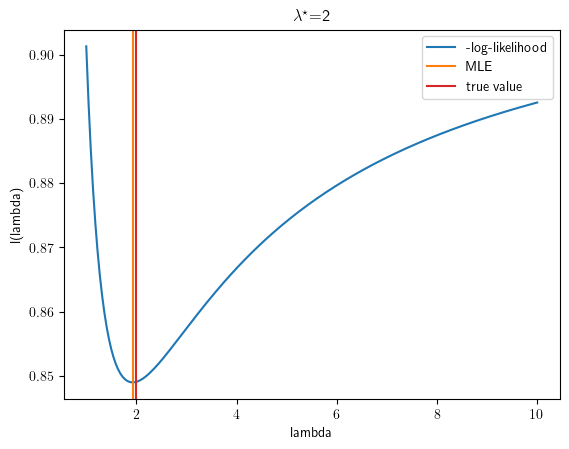

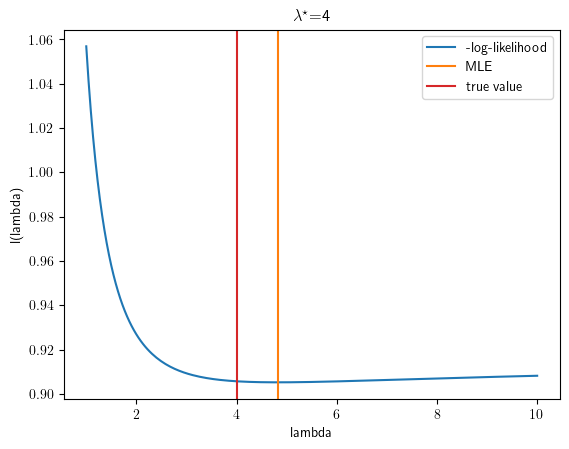

In [8]:
# Solution
for dataset_decay, lambda_star, lambda_hat in zip(dataset_decays,lambda_stars, lambda_hats):
    xs = np.linspace(1,10,200)
    ys = [ ell(x, xmin, xmax, dataset_decay) for x in xs]
    plt.plot(xs, ys, label = "-log-likelihood")
    plt.xlabel("lambda")
    plt.ylabel("l(lambda)")
    plt.axvline(x=lambda_hat, color = "tab:orange", label="MLE")
    plt.axvline(x=lambda_star, color = "tab:red", label="true value")
    plt.title(rf"$\lambda^\star$={lambda_star}")
    plt.legend()
    plt.show()

**1.2.4** For both cases $\lambda^\star=2$ and $\lambda^\star=4$, perform the following for $10$ independent trials:

Repeat 1.2.2 (obtaining the MLE) for a $n$ spaced between $10,1000$ on a logarithmic scale. Generate a plot containing, for each of the $10$ trials (in the same plot), the obtained MLE $\hat{\lambda}$ on the $y$-axis as a function of $n$ on the $x$-axis. Use logarithmic scale for both the axes. Add a horizontal line at $y=\lambda_*$ for comparison. 
- What do you observe as $n$ increases?
- How does the behavior differ between the two cases $\lambda^\star=2$ $\lambda^\star=4$?

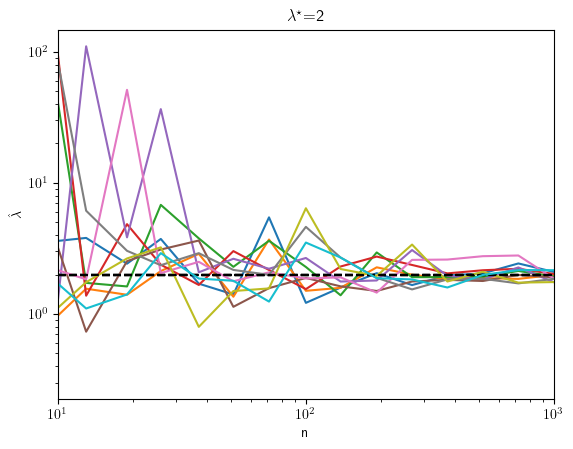

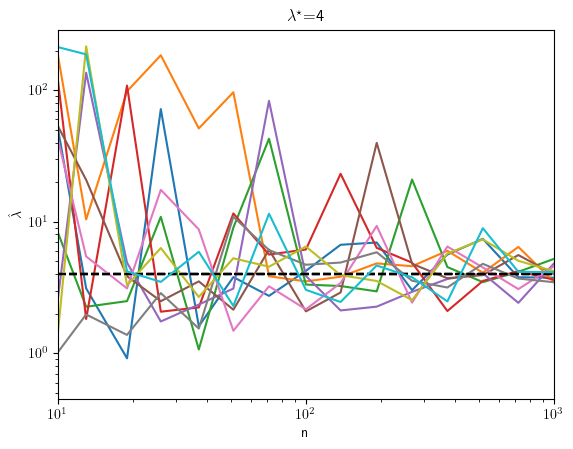

In [9]:
for lambda_star in lambda_stars:

    #generate n linearly spaced values between 10 and 1000:
    ns = np.geomspace(10,1000, 15).astype(int)
    num_exp=10
    for i in range(num_exp):
        lambda_hats = []
        for n in ns:
            dataset_decay = generate_dataset_decay(n, lambda_star, xmin, xmax)
            lambda_hats.append((scipy.optimize.minimize(lambda a: ell(a, xmin, xmax, dataset_decay), 0.1).x)[0])

        plt.hlines(lambda_star, ns[0], ns[-1], color='k', linestyles='--', label=r'$\lambda^*$')
        plt.xscale('log')
        plt.yscale('log')
        plt.plot(ns, lambda_hats)    

    plt.xlim(10,1000)
    plt.xlabel("n")
    plt.ylabel(r"$\hat{\lambda}$")
    plt.title(rf"$\lambda^\star$={lambda_star}")
    plt.show()
    
    
    
        

We observe that as $n$ increases, the fluctations of $\hat{\lambda}$ around $\lambda^\star$ decrease in magnitude. Furthermore, the convergence to $\lambda^\star$ with increasing $n$ appears to be faster for $\lambda^\star=2$ i.e. when $\lambda^\star$ is within the range of measurements.

**1.2.5** We will now estimate the standard deviation of $\hat{\lambda}$ and compare it with the prediction using Fisher information.

Fix $n=1000$. For both cases $\lambda^\star=2$ and $\lambda^\star=4$, generate $k=1000$ independent datasets each of size $n$. Let $\hat{\lambda}_i$ denote the Maximum Likelihood estimate for the $i_{th}$ dataset, $i \in [k]$. Estimate the standard deviation of $\hat{\lambda}$ empirically as follows:

$$\hat{\sigma}_n \coloneqq \sqrt{\frac{1}{k}\sum_{i=1}^k[\hat{\lambda}_i-\bar{\lambda}]^2}.$$

where $\bar{\lambda}=\frac{1}{k}\sum_{i=1}^k\hat{\lambda}_k$ is the mean of $\hat{\lambda}$ across the $k$ datasets.

The above quantity asymptotically converges to the standard deviation of the MLE $\hat{\lambda}$ around the asymptotic mean $\lambda_*$. Recall from Equation 9.36 in the notes the definition of the Fisher information:

$$I(\lambda^\star)= \mathbb{E}_{\rho(x|\lambda^\star)}[(\frac{\partial \log \rho(x|\lambda)}{\partial \lambda}\vert_{\lambda=\lambda^\star})^2].$$

Analytically compute $\frac{\partial \log \rho(x|\lambda)}{\partial \lambda}$ and estimate $I$ by taking the empirical mean of $(\frac{\partial \log \rho(x|\lambda)}{\partial \lambda}\vert_{\lambda=\hat{\lambda}_i})^2$, for $i \in [k]$ over the datasets generated above. Note that we set $\lambda=\hat{\lambda}_i$ (the estimated mean for the $i_{th}$ dataset) instead of $\lambda=\lambda^\star$ since $\lambda^\star$ is unknown. From Theorem 9 in the notes, we expect that as $n \rightarrow \infty$:

$$\hat{\sigma}_n \rightarrow 1/\sqrt{nI(\lambda^\star)}.$$

Compare the value $\hat{\sigma}_n$ against the estimate of $1/\sqrt{nI(\lambda^\star)}$ (both obtained using the estimates $\hat{\lambda}_i$ for $i \in [k]$).

Compare the values for $\lambda^\star=2$ and $\lambda^\star=4$.

Using the evaluated standard deviation, we can report our estimate for $\lambda^\star$ as  $\lambda^\star = \bar{\lambda} \pm \hat{\sigma}_n$. 

In [23]:
def dlog_rho_dt(l, x, xmin, xmax):
    c=(np.exp(-xmin/l)-np.exp(-xmax/l))
    rho = np.exp(-x/l)/(l*c)
    drho_dt = x*np.exp(-x/l)/(l**3*c)-np.exp(-x/l)/c**2*(xmin*np.exp(-xmin/l)-xmax*np.exp(-xmax/l))/(l**3)-1/l**2*np.exp(-x/l)/c
    return drho_dt/rho

for lambda_star in lambda_stars:
    num_exp=1000
    n = 10000
    lambda_hat_list=np.empty(shape=num_exp)
    I_list=np.empty(shape=num_exp)
    for i in range(num_exp):
            dataset_decay = generate_dataset_decay(n, lambda_star, xmin, xmax)
            lambda_hat = (minimize(lambda a: ell(a, xmin, xmax, dataset_decay), 0.1).x)[0]
            lambda_hat_list[i]=lambda_hat
            I_list[i]= np.mean(dlog_rho_dt(lambda_hat, dataset_decay, xmin, xmax)**2)
    sig = np.std(lambda_hat_list)
    I = np.mean(I_list)
    lambda_bar = np.mean(lambda_hat_list)
    print(r'True lambda:', lambda_star)
    print(r'Estimated lambda', lambda_bar)
    print(r'Empirical estimate of the standard deviation:', sig)
    print(r'Estimate of the standard deviation through Fisher information :', 1/np.sqrt(n*I))

True lambda: 2
Estimated lambda 2.0004643310067056
Empirical estimate of the standard deviation: 0.05859116910143808
Estimate of the standard deviation through Fisher information : 0.057382867915163144
True lambda: 4
Estimated lambda 4.011132651990709
Empirical estimate of the standard deviation: 0.2262524572331624
Estimate of the standard deviation through Fisher information : 0.2216281857137506


We observe that the standard deviation is much larger for case $2$ i.e when $\lambda^\star$ is outside the measurement range.

**1.2.6** 
The ```scipy.optimize.minimize``` uses under the hood sophisticated minimization methods, but for the sake of the argument let us imagine that it is using gradient descent to minimize the function $\ell$. Discuss the following points:

- does gradient descent converge to the global optimum in general (i.e. not in this specific case), and what are the consequences for the MLE if it does not? 
- In this case, does gradient descent converge to the global optimum of the likelihood?

Motivate your answers.

**Solution**

In general, the maximum likelihood estimator is the global maximum of the likelihood. In a generic problem, the likelihood may have local maxima, and gradient descent may return a wrong estimate of the MLE.

In our case, the function we are minimising, which is a proxy for the maximisation of the likelihood, seems to have only one global minimum in the interval $2 < \lambda < 10$ (see plot above). Thus we may avoid worrying about local extrema as long as we initialise our optimiser in this region.

## Ex 2: The lighthouse

A lighthouse is placed on a small island in front of the coastline. 
In a coordinate system in which the coast is the $x$ axis, and the $y$ axis points towards open sea, the island is at position $(\alpha_*, 1)$.
The lighthouse emits a series of short flashes at random intervals and hence in random directions $\theta$ (uniformly at random over the full angle of $2\pi$).
These pulses are intercepted on the coast by photo-detectors that record only the fact that a flash has occurred, but not the angle from which it came.

In this exercise, we will consider the estimation task of finding the true position $\alpha_*$ of the lighthouse along the coastline, assuming that 
- the angle $\theta$ at which each light pulse is emitted is a uniformly distributed random variable on the interval $(-\pi/2, \pi/2)$ (the angle is measured with respect to the negative-vertical axis, see figure)
- a dataset of $n$ detected positions $x_1, x_2, \dots, x_n$ is given (each detection is statistically independent from the others).

![](lighthouse.png)

### Ex 2.1: simulating the lighthouse, i.e. generating the dataset of measurements

Your first task is to simulate this physical system, namely to generate the dataset $x_1, x_2, \dots, x_n$ given the true value $\alpha_*$.
To do this, we are going to generate randomly the angle $\theta_i$ at which a light pulse is emitted and we will compute the corresponding detection position $x_i$ as
$$
    x_i = \tan(\theta_i) + \alpha_* \, .
$$

**2.1.1** Write a function that takes as input $n$ and $\alpha_*$ and generates the dataset as a lenght $n$ vector. Recall that each angle is independent from the others, and uniformly distributed in the interval $(-\pi/2, \pi/2)$.

In [9]:
# Solution
def generate_dataset(alpha_star, n):
    thetas = (np.random.random(n) - 0.5) * np.pi
    return alpha_star + np.tan(thetas)

**2.1.2** Using the change of variables formula, we can show that the probability density function of the random variable $x(\theta)$ is given by
$$
    \rho_{x}(x | \alpha_*) = \frac{1}{\pi(1+(x - \alpha_*)^2)} \, .
$$

We wish to compare the above density with the frequencies of $x$ in a dataset of samples.

Generate a dataset with $\alpha_* = 20$ and $n=10000$ and plot its histogram. 
Set manually the bins to ```range(-300,300)``` (this means that we use 600 bins with width 1 on the interval $(-300,300)$) and use the option ```density = True``` in the histogram (to plot frequencies instead of counts on the y axis), and plot in black the p.d.f. $\rho_x$ given above on top of it.
Plot from $x=-100$ to $x=100$.
Add a vertical line at $x = \alpha_*$ in red.
Add a legend and labels.

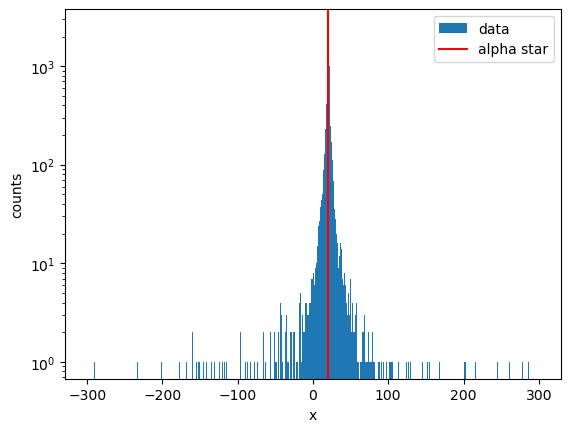

In [ ]:
# Solution
astar = 20
n = 10000
data = generate_dataset(astar, n)
plt.hist(data, bins = range(-300,300), label = "data", density = True)
plt.axvline(astar, color = 'red', label = "alpha star")
xs = np.linspace(-100,100,1000)
ys = 1/(1+(xs - 20)**2)/np.pi
plt.plot(xs, ys, color = "black", label = "analytical p.d.f.")
plt.xlim(-100,100)
plt.yscale('log')
plt.xlabel('x')
plt.ylabel('empirical pdf')
plt.legend()
plt.show()

**2.1.3** Answer the following questions.

1. Around which value of $x$ is the histogram peaked? Motivate your answer.
2. Which values of the angle $\theta$ correspond to the extreme values (the rare outliers)?

**Solution**

1. The histogram is peaked around the value of $\alpha_*$, as it should be given that most angles will produce detected events around the corresponding position on the coastline. One could also consider a more mathematical viewpoint, reasoning how the non-linear function `tan` alters uniformly spaced points: it packs together around 0 most of the points, and spreads the points next to $\pm \pi/2$ on infinitely long intervals.
2. The outliers are single events detected vey far from the peak due to the corresponding angle being close to $\pm \pi/2$.

### Ex 2.2: estimation of $\alpha_*$ through maximum likelihood

In this section, we implement the maximum likelihood estimator for $\alpha$, and use it to estimate $\alpha_*$ in the given dataset.

**2.2.1** 
Use ```np.load``` to load the file "data-lighthouse.npy" into a variable called ```dataset```. 
This will be your set of observations for this part of the exercise, in which we will try to estimate the value $\alpha_*$ used to generate the dataset. 
How many measurements does it contain?

In [27]:
# Solution
dataset = np.load("data-lighthouse.npy")
print(dataset.shape)

(50,)


**Solution** 

It contains 50 measurements.

**2.2.2** Prove that the maximum likelihood estimator (MLE) $\hat{\alpha}$ is given by
$$
\hat{\alpha} = \arg\min_{\alpha} \sum_{i=1}^n \log (1+(x_i - \alpha)^2) = \arg\min_{\alpha} f(\alpha, \{x_i\}_{i=1}^n)
$$
Type your derivation in a Markdown cell using LaTeX.

Hints: 
- you can follow and adapt the many examples of MLE given in class to this specific problem. 
- It is useful to maximise the log-likelihood instead of the likelihood to convert products into sums (recall that logs do not alter the position of maxima). 
- $\max[f(x)] = \min[- f(x)]$.

**Solution**

The maximum likelihood estimator is 
$$
\hat{\alpha} 
= \argmax_{\alpha} \prod_{i=1}^n \frac{1}{\pi(1+(x_i - \alpha)^2)}
= \argmax_{\alpha} \sum_{i=1}^n \log \frac{1}{\pi(1+(x_i - \alpha)^2)}
= \arg\min_{\alpha} \sum_{i=1}^n \log (1+(x_i - \alpha)^2) - n \log \pi
= \arg\min_{\alpha} \sum_{i=1}^n \log (1+(x_i - \alpha)^2)
$$

**2.2.3** Write a function that takes as input $\alpha$ and the dataset (a length $n$ vector) and computes $f(\alpha, \{x_i\}_{i=1}^n)$.

In [28]:
# Solution
def f(a, dataset):
    return np.sum(np.log(1+(dataset - a)**2))

**2.2.4** Plot the function $f(\alpha, \{x_i\}_{i=1}^n)$ as a function of $\alpha$ and the given dataset. Plot it for $-10 < \alpha < 30$.
What can you deduce about the value of $\hat{\alpha}$ from the plot?

Text(0, 0.5, 'f(alpha)')

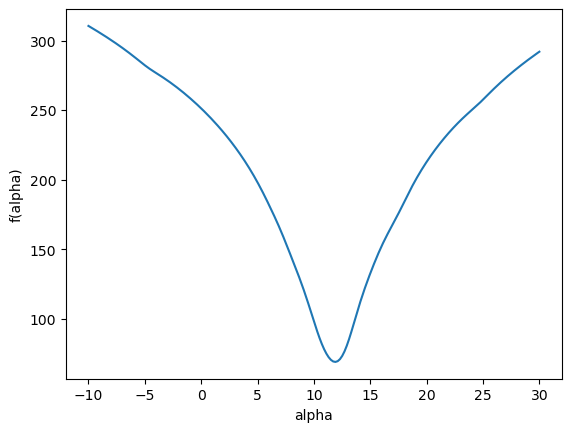

In [29]:
# Solution 
xs = np.linspace(-10,30,200)
ys = [ f(x, dataset) for x in xs]
plt.plot(xs, ys)
plt.xlabel("alpha")
plt.ylabel("f(alpha)")

**Solution**

The MLE stimator is in the surrounding of $\alpha \approx 12$.

**2.2.5** Minimize numerically $f$ for your dataset and compute the MLE. Use ```x0=0``` for the initial condition of the minimization. Print the MLE that you obtain.

In [30]:
# Solution
ahat = (scipy.optimize.minimize(lambda a: f(a, dataset), 0).x)[0]
print(ahat)

11.887987569217566


**2.2.6** 
Reproduce the plot you did in 1.2.4.. 
Additionaly, plot a vertical line at  $x = \hat{\alpha}$ and add a legend.

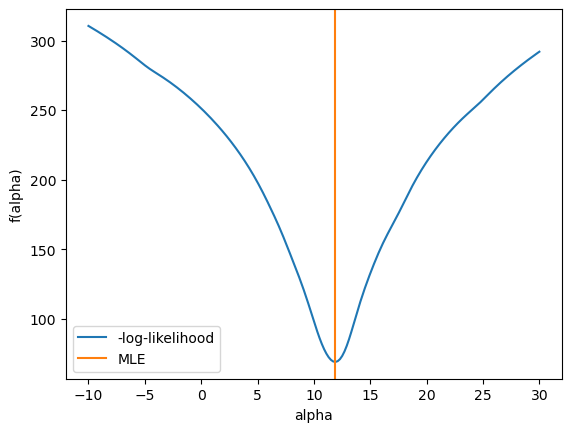

In [16]:
# Solution 
xs = np.linspace(-10,30,200)
ys = [ f(x, dataset) for x in xs]
plt.plot(xs, ys, label = "-log-likelihood")
plt.xlabel("alpha")
plt.ylabel("f(alpha)")
plt.axvline(x=ahat, color = "tab:orange", label="MLE")
plt.legend()